In [1]:
import numpy as np
from NonlinearController.mpc_utils import *
from NonlinearController.controllers import *
from NonlinearController.model_utils import *
from NonlinearController.lpv_embedding import *
import deepSI

In [2]:
model = deepSI.load_system("NonlinearController/trained_models/unbalanced/ObserverUnbalancedDisk_dt01_nab_4_SNR_30_e250")

nx = model.nx
nu = model.nu if model.nu is not None else 1
ny = model.ny if model.ny is not None else 1

In [3]:
sim_steps = 100
#w = np.random.normal(size=(nu,sim_steps))
w = np.ones((1,sim_steps))

In [4]:
norm = model.norm
u = norm_input(w, norm)

In [5]:
# LPV embedding
lpv_A, lpv_B, lpv_C, corr_f, corr_h = lpv_embedding(model)
f0 = np.array(corr_f.elements())[np.newaxis].T
h0 = np.array(corr_h.elements()) #make sure this has the correct dimensions for ny>1

A = np.zeros((nx,nx))
B = np.zeros((nx,nu))
C = np.zeros((ny,nx))

x1 = np.zeros((nx,1))
x0 = np.zeros((nx,1))
u1 = np.zeros((nu,1))
u0 = np.zeros((nu,1))

log_y = np.zeros((ny,sim_steps))

for i in range(sim_steps):
    u0[:,0] = u[:,i]

    A[:,:] = lpv_A(x0,u0)
    B[:,:] = lpv_B(x0,u0)
    C[:,:] = lpv_C(x0,u0)

    x0 = A @ x0 + B @ u0 + f0
    
    log_y[:,i] = C @ x0[:,0] + h0

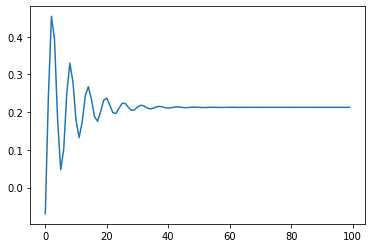

In [6]:
log_z = denorm_output(log_y, norm)

plt.plot(log_z[0,:])

In [ ]:
# Velocity LPV embedding
lpv_A, lpv_B, lpv_C = velocity_lpv_embedding(model)

A = np.zeros((nx,nx))
B = np.zeros((nx,nu))
C = np.zeros((ny,nx))

dx0 = np.zeros((nx,1))
u1 = np.zeros((nu,1))
u0 = np.zeros((nu,1))
du0 = np.zeros((nu,1))
y0 = np.zeros((ny,1))
y_1 = np.zeros((ny,1))
dy0 = np.zeros((ny,1))

log_y = np.zeros((ny,sim_steps))

for i in range(sim_steps):

    A[:,:] = lpv_A(x0,dx0,u0,du0)
    B[:,:] = lpv_B(x0,dx0,u0,du0)
    C[:,:] = lpv_C(x0,dx0,u0,du0)

    dx0 = A @ dx0 + B @ du0

    dy0 = C @ dx0

    y0 = dy0 + y_1
    y_1 = log_y[:,i]

    u1[:,0] = u[:,i]
    du = u1 - u0
    u0 = u1

    log_y[:,i] = y0[:,0]

In [ ]:
dx0

In [ ]:
vel_log_z = denorm_output(log_y, norm)

plt.plot(vel_log_z[0,:])

In [ ]:
plt.plot(log_z[0,:] - vel_log_z[0,:])